## Prerequisite

Make sure you ran `snakemake` in this directory and have obtained all the files (stored under `output/`).

### Config

In [1]:
import kipoi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snakemake

# Get all models and interval_sets for which we computed the predictions
models, interval_sets = list(zip(*list(zip(*snakemake.utils.listfiles("output/{model}/{interval_set}.tsv")))[1]))
models = kipoi.utils.unique_list(models)
interval_sets = kipoi.utils.unique_list(interval_sets)

## Loading predictions from the tsv output

In [2]:
merge_cols = ['metadata/ranges/chr', 'metadata/ranges/center', 'metadata/ranges/id', 'interval_set']

def read_preds_tsv(model, interval_set, output_dir):
    df = pd.read_table("{}/{}/{}.tsv".format(output_dir, model, interval_set))
    df['interval_set'] = interval_set
    df['metadata/ranges/center'] = (df['metadata/ranges/start'] + df['metadata/ranges/end']) //2
    del df['metadata/ranges/start']
    del df['metadata/ranges/end']
    del df['metadata/ranges/strand']
    df.set_index(merge_cols, inplace=True)
    assert df.columns.str.startswith("preds").all()
    df.columns = df.columns.str.replace("preds", model)
    
    
    if len(df.columns) > 1:
        # multi-task model
        try:
            descr = kipoi.get_model_descr(model)
            df.columns = model + "/" + pd.Series(descr.schema.targets.column_labels)
        except:
            pass
    return df

In [3]:
def logit(df):
    if np.any(df < 0) or np.any(df > 1):
        # values not from [0,1]
        return df
    df_logit = np.log(df + 1e-10/ (1-df))
    return df_logit

In [4]:
df = pd.concat([logit(pd.concat([read_preds_tsv(m, interval_set, output_dir='output') 
                      for interval_set in interval_sets], axis=0)) 
                for m in models], axis=1)

In [5]:
df.min()

Basset/8988T                                        -23.0259
Basset/AoSMC                                        -23.0259
Basset/Chorion                                      -23.0259
                                                      ...   
DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF    -5.2260
DeepBind/Homo_sapiens/TF/D00351.009_ChIP-seq_EGR1    -5.3175
DeepBind/Homo_sapiens/TF/D00356.010_ChIP-seq_ELF1    -4.1814
Length: 174, dtype: float64

In [6]:
df.head()

Basset/8988T  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 
chr22               29765964               0                  random             -3.5245   
                    31247572               1                  random             -6.5152   
                    15916363               2                  random            -23.0259   
                    30059280               3                  random             -3.9343   
                    25383393               4                  random             -5.3061   

                                                                            Basset/AoSMC  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 
chr22               29765964               0                  random             -4.5970   
                    31247572               1                  random             -2.9809   
                    15916363               2                  random            -23.0259   
                    30059280               3                  random             -4.3501   
                    25383393               4                  random             -9.8829   

                                                                            Basset/Chorion  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                   
chr22               29765964               0                  random               -4.4649   
                    31247572               1                  random               -3.0507   
                    15916363               2                  random              -23.0259   
                    30059280               3                  random               -4.2738   
                    25383393               4                  random               -5.5929   

                                                                            Basset/CLL  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set               
chr22               29765964               0                  random           -5.0453   
                    31247572               1                  random           -5.0699   
                    15916363               2                  random          -23.0259   
                    30059280               3                  random           -4.1000   
                    25383393               4                  random           -4.9490   

                                                                            Basset/Fibrobl  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                   
chr22               29765964               0                  random               -7.0977   
                    31247572               1                  random               -6.8025   
                    15916363               2                  random              -23.0259   
                    30059280               3                  random               -3.9159   
                    25383393               4                  random               -5.6309   

                                                                            Basset/FibroP  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                  
chr22               29765964               0                  random              -4.9139   
                    31247572               1                  random              -5.0648   
                    15916363               2                  random             -23.0259   
                    30059280               3                  random              -4.6041   
                    25383393               4                  random              -4.3446   

                                                                            Basset/Gliobla  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 

### Average prediction per interval_set per model

In [7]:
df_agg = df.groupby(df.index.get_level_values("interval_set")).agg('mean').T

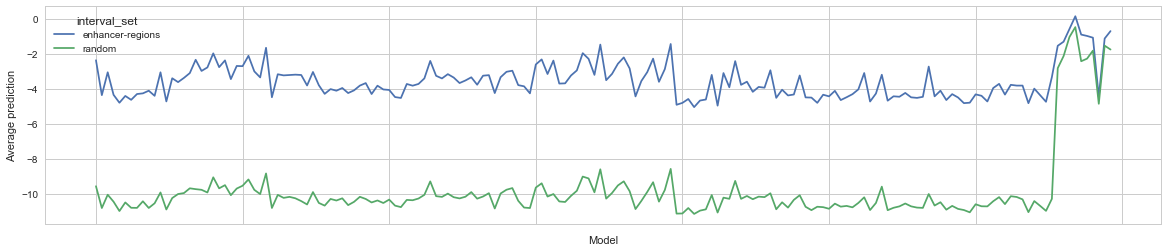

In [8]:
df_agg.plot(figsize=(20,4))
plt.xlabel("Model")
plt.ylabel("Average prediction");

In [9]:
# See the sorted list
# print((df_agg['enhancer-regions'] - df_agg['random']).sort_values(ascending=False)[:200].to_string())

## Loading predictions from the hdf5 output

In [10]:
from kipoi.readers import HDF5Reader

Quick intro to HDF5Reader

In [11]:
f = "output/Basset/random.h5"

In [12]:
r = HDF5Reader(f)
r.open()

In [13]:
r.ls()

[('/metadata/ranges/chr', <HDF5 dataset "chr": shape (6365,), type "|O">),
 ('/metadata/ranges/end', <HDF5 dataset "end": shape (6365,), type "<i8">),
 ('/metadata/ranges/id', <HDF5 dataset "id": shape (6365,), type "|O">),
 ('/metadata/ranges/start', <HDF5 dataset "start": shape (6365,), type "<i8">),
 ('/metadata/ranges/strand',
  <HDF5 dataset "strand": shape (6365,), type "|O">),
 ('/preds', <HDF5 dataset "preds": shape (6365, 164), type "<f4">)]

In [14]:
# load the values
d = HDF5Reader.load(f, unflatten=False)

In [15]:
d.keys()

dict_keys(['/metadata/ranges/chr', '/metadata/ranges/end', '/metadata/ranges/id', '/metadata/ranges/start', '/metadata/ranges/strand', '/preds'])

In [16]:
def df2index(df):
    return pd.MultiIndex.from_arrays([df.values[:,i] for i in range(df.shape[1])], names=list(df.columns))


def read_preds_h5(model, interval_set, output_dir):
    d = HDF5Reader.load("{}/{}/{}.h5".format(output_dir, model, interval_set), unflatten=False)
    preds = d.pop("/preds")
    
    if preds.ndim == 1:
        preds = preds[:, np.newaxis]
    assert preds.ndim == 2  # this example works only with 2 dim output arrays
    
    metadata_table = pd.DataFrame(d)
    metadata_table.columns = metadata_table.columns.str.replace("^/", "")
    metadata_table['interval_set'] = interval_set
    metadata_table['metadata/ranges/center'] = (metadata_table['metadata/ranges/start'] + metadata_table['metadata/ranges/end']) //2
    del metadata_table['metadata/ranges/start']
    del metadata_table['metadata/ranges/end']
    del metadata_table['metadata/ranges/strand']
    metadata_table = metadata_table[merge_cols]  # re-order
    
    if preds.shape[1] > 1:
        descr = kipoi.get_model_descr(model)
        return pd.DataFrame(preds, 
                            columns=model + "/" + pd.Series(descr.schema.targets.column_labels),
                            index=df2index(metadata_table))
    else:
        return pd.DataFrame(preds, columns = model + "/" + pd.Series(np.arange(preds.shape[1]), dtype=str),
                            index=df2index(metadata_table))

In [17]:
df = pd.concat([logit(pd.concat([read_preds_h5(m, interval_set, output_dir='output') 
                      for interval_set in interval_sets], axis=0)) 
                for m in models], axis=1)

In [18]:
df.head()

Basset/8988T  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 
chr22               29765964               0                  random             -3.5245   
                    31247572               1                  random             -6.5152   
                    15916363               2                  random            -23.0259   
                    30059280               3                  random             -3.9343   
                    25383393               4                  random             -5.3061   

                                                                            Basset/AoSMC  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 
chr22               29765964               0                  random             -4.5970   
                    31247572               1                  random             -2.9809   
                    15916363               2                  random            -23.0259   
                    30059280               3                  random             -4.3501   
                    25383393               4                  random             -9.8829   

                                                                            Basset/Chorion  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                   
chr22               29765964               0                  random               -3.2162   
                    31247572               1                  random               -5.5421   
                    15916363               2                  random              -23.0259   
                    30059280               3                  random               -3.6008   
                    25383393               4                  random               -5.0903   

                                                                            Basset/CLL  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set               
chr22               29765964               0                  random           -4.8977   
                    31247572               1                  random           -3.5417   
                    15916363               2                  random          -23.0259   
                    30059280               3                  random           -4.4388   
                    25383393               4                  random           -5.4448   

                                                                            Basset/Fibrobl  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                   
chr22               29765964               0                  random               -1.6355   
                    31247572               1                  random               -3.0670   
                    15916363               2                  random              -23.0259   
                    30059280               3                  random               -2.2105   
                    25383393               4                  random               -3.4841   

                                                                            Basset/FibroP  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                  
chr22               29765964               0                  random              -2.5358   
                    31247572               1                  random              -3.6081   
                    15916363               2                  random             -23.0259   
                    30059280               3                  random              -2.9649   
                    25383393               4                  random              -5.2407   

                                                                            Basset/Gliobla  \
metadata/ranges/chr metadata/ranges/center metadata/ranges/id interval_set                 